In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis, get_time_plate_info_long_from_analysis
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)

all_analysis_folders = get_analysis_folders()
#for P
plates = [
"416_20230705",
"427_20230707",
"420_20230705",
"431_20230627",
"474_20230807",
"460_20230807",
"464_20230807",
"440_20230723",
"436_20230717",
"443_20230720",
"439_20230804",
"470_20230709",
'478_20230814', '468_20230809', '447_20230821', '487_20230922',
       '492_20230901', '471_20230821', '486_20231009',
       '494_20230908', '482_20230908', '495_20231013', '463_20231013',
       '491_20231013', '481_20231005', '483_20231005',
    '490_20231003',
       '485_20230929',
]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
folders,time_plate_info = get_time_plate_info_long_from_analysis(analysis_folders,False)
time_plate_info['unique_id'] = time_plate_info['unique_id'].replace(47020230709,47020230802)
time_plate_info=time_plate_info[time_plate_info['Plate']!=431]
# time_plate_info['time_since_begin_hour'] = time_plate_info['time_since_begin_h'].dt.total_seconds() / 3600.0
# time_plate_info['time_since_begin_hour'] = time_plate_info['time_since_begin_h']

In [3]:
import pandas as pd

# Assuming df is your DataFrame
columns_to_check = [f'SA_region_{i}' for i in range(18)] + [f'length_density_region_{i}' for i in range(18)]

# Filter DataFrame rows where any of the specified columns have NaN values
df_filtered = time_plate_info[time_plate_info[columns_to_check].isna().any(axis=1)]

# Find the unique ids corresponding to those rows
unique_ids_with_nans = df_filtered['unique_id'].unique()

print("Unique IDs with at least one NaN in specified columns:", unique_ids_with_nans)


Unique IDs with at least one NaN in specified columns: [47420230807]


In [4]:
[plate for plate in plates if int(plate) not in time_plate_info['unique_id'].unique()]

['431_20230627',
 '470_20230709',
 '495_20231013',
 '463_20231013',
 '491_20231013']

In [5]:
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df['time_since_begin_hour'] = df['time_since_begin_h'].dt.total_seconds() / 3600.0
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)

In [6]:
for i in range(18):
    calculate_integral(time_plate_info,f'SA_region_{i}',f'integrated_SA_{i}')
for i in range(18):
    calculate_integral(time_plate_info,f'length_density_region_{i}',f'integrated_L_{i}')


In [7]:
coarse_to_basic_mapping = {
    1: [1, 2],
    2: [3, 8],
    3: [4, 5],
    4: [6, 7],
    5: [9, 10],
    6: [11, 12],
    7: [13],
    8: [14, 15],
    9: [16, 17, 18]
}

# Mapping for "simple" to "basic"
simple_to_basic_mapping = {
    0: list(range(1, 11)),
    1: list(range(11, 19))
}
sub_to_basic_mapping = {
    0: list(range(1, 19)),
}

In [8]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import *
from amftrack.notebooks.P_experiment.helper import get_polygons
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')

%matplotlib widget
C_max2 = 1.53

def fit_function(x, C_max):
    return 1+C_max * 1/x**(3/2)
# Read the Excel file
path = r'C:\Users\coren\Documents\PhD\Pexperiment'
path_excel = os.path.join(path,'summary.xlsx')
df = pd.read_excel(path_excel)
df['date_from_unique_id'] = pd.to_datetime(df['unique_id'].str.split('_').str[1], format='%Y%m%d')
    
# Convert 'day' column to datetime
df['day_sample'] = pd.to_datetime(df['day_sample'], format='%Y%m%d')  # Update the format as necessary
df['day_start'] = pd.to_datetime(df['start'], format='%Y%m%d')  # Update the format as necessary

df['time_elapsed'] = df['day_sample'] - df['day_start']
df['time_elapsed_day'] = df['time_elapsed'].dt.days
df['time_since_crossing'] = df['day_sample'] - df['date_from_unique_id']
df['t2 (day)'] = df['time_since_crossing'].dt.days
df['t1 (day)'] = df['time_elapsed_day']-df['t2 (day)']
df['treatment'] = df['treatment'].fillna('none')
df['wet_weight_measured'] = df['wet weight']

df['wet weight'] = df['wet weight']-df['lost weight']
df['totP (ug)'] = df['totP (ug)'] * fit_function(df['totP (ug)'], C_max2)
df['Sample_name'] = df['Sample_name'].str.replace('bottom','0')
df['Sample_name'] = df['Sample_name'].str.replace('up','1')
df['Sample_name'] = df['Sample_name'].str.replace('top','1')
df['Sample_name'] = df['Sample_name'].str.replace('agar','0')



df = df.loc[df['plate']!=487]
df = df.loc[df['type'] == 'agar']
df['pos'] = df['Sample_name'].str.split('-').str.get(1).astype(int)

time_plate_info.sort_values(['unique_id', 'time_since_begin_h'], inplace=True)

# Group by unique_id and take the last entry for each group
last_values = time_plate_info.groupby('unique_id').last().reset_index()

# Create a function to map 'pos' to the corresponding integrated_Ldens_i value
def get_integrated_density(row):
    unique_id = row['unique_id']
    pos = row['pos']
    arrangement = row['arrangement']
    if arrangement == 'basic':
        col_names = [f'integrated_SA_{pos-1}']
    if arrangement == 'simple':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in simple_to_basic_mapping[pos]]
    if arrangement == 'coarse':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in coarse_to_basic_mapping[pos]] 
    if arrangement == 'sub':
        col_names = [f'integrated_SA_{basic_pos-1}' for basic_pos in sub_to_basic_mapping[pos]] 
    if not unique_id is np.nan:
        last_value_row = last_values[last_values['unique_id'] == int(unique_id)]
        return np.sum(last_value_row[col_names].values) if not last_value_row.empty else None
    else:
        return(None)
df['integrated_SA'] = df.apply(get_integrated_density, axis=1)

grouped = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum',
    'integrated_SA':"sum"
}).reset_index()

# Rename columns
grouped.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped.columns]
grouped = grouped.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6

df['C_P'] = df['totP (ug)'] / df['wet weight']
df['P_content'] = df['totP (ug)'] / df['dry weight']/1e6
# df = df[df['type'] != 'sub']

grouped = grouped[grouped['plate']!=487]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df['arrangement'].unique()

array(['basic', 'simple', 'coarse', 'sub'], dtype=object)

In [10]:
df['integrated_SA_C']=df['integrated_SA']/df['wet weight']
# grouped = dfgrouped = df.groupby(['plate', 'type',"time_elapsed_day","t1 (day)","treatment",'t2 (day)']).agg({'totP (ug)': 'sum', 'wet weight': 'sum','dry weight' : "sum",'integrated_SA':"sum"}).reset_index()
grouped['C_P'] = grouped['totP (ug)'] / grouped['tot_wet_weight']
grouped['P_content'] = grouped['totP (ug)'] / grouped['dry weight']/1e6
grouped['integrated_SA_C']=grouped['integrated_SA']/grouped['tot_wet_weight']
tot_weights = grouped[grouped['type'].isin(["agartot", "rootagartot"])].set_index(['plate', 'type'])['wet_weight_measured'].to_dict()

# Function to determine the 'measured_tot_wet_weight' based on conditions
def get_tot_weight(row):
    if row['type'] == 'agar' and (row['plate'], 'agartot') in tot_weights:
        return tot_weights[(row['plate'], 'agartot')]
    elif row['type'] == 'rootagar' and (row['plate'], 'rootagartot') in tot_weights:
        return tot_weights[(row['plate'], 'rootagartot')]
    else:
        return row['wet_weight_measured']

# Apply the function to get 'measured_tot_wet_weight' column
grouped['measured_tot_wet_weight'] = grouped.apply(get_tot_weight, axis=1)
grouped= grouped[grouped['type'] != 'rootagartot']
grouped= grouped[grouped['type'] != 'agartot']
# Step 1: Identify plates that don't have any rows with type "agartot"
plates_with_agartot = grouped[grouped['type'] == 'rootagartot']['plate'].unique()
valid_plates = grouped[~grouped['plate'].isin(plates_with_agartot)]

# Step 2: Compute the average "wet weight" for type 'agar' and 'rootagar'
average_wet_weight_agar = valid_plates[valid_plates['type'] == 'agar']['measured_tot_wet_weight'].mean()
average_wet_weight_rootagar = valid_plates[valid_plates['type'] == 'rootagar']['measured_tot_wet_weight'].mean()

# Step 3: Replace rows in the 'average weight' column accordingly
grouped['average weight'] = None  # Initialize column with None values
grouped.loc[grouped['type'] == 'agar', 'average weight'] = average_wet_weight_agar
grouped.loc[grouped['type'] == 'rootagar', 'average weight'] = average_wet_weight_rootagar
grouped.loc[grouped['type'] == 'agar', 'fullP'] = grouped.loc[grouped['type'] == 'agar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'agar', 'C_P']
grouped.loc[grouped['type'] == 'rootagar', 'fullP'] = grouped.loc[grouped['type'] == 'rootagar', 'measured_tot_wet_weight'] *grouped.loc[grouped['type'] == 'rootagar', 'C_P']
grouped.loc[grouped['type'] == 'root', 'fullP'] = grouped.loc[grouped['type'] == 'root', 'totP (ug)']
totP_theory = 100
grouped['scaling_factor'] = totP_theory/grouped.groupby('plate')['fullP'].transform('sum')

# Multiply 'fullP' by the scaling factor to get 'fullP_rescaled'
grouped['fullP_rescaled'] = grouped['fullP'] * grouped['scaling_factor']

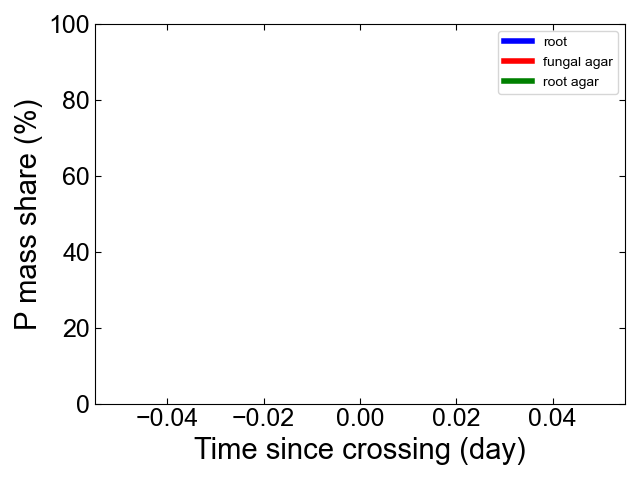

In [11]:
from matplotlib.lines import Line2D
select= grouped[grouped['fullP']>0]
select= select[select['treatment']=='100P']
select = select[select['plate']!=431]
select = select[select['plate']!=487]

t2_values = select['t2 (day)'].unique()
color_dict = {
    'root': 'blue',
    'agar': 'red',
    'rootagar': 'green'
}
# Plotting
fig, ax = plt.subplots()
blues = []
reds = []
greens = []
t2s = []
for t2 in sorted(t2_values):
    plate_data = select[select['t2 (day)'] == t2]
    
    bottom = 0
    k=0
    for type_ in ['root', 'agar', 'rootagar']:
        value = plate_data[plate_data['type'] == type_]['fullP_rescaled'].mean()
            # print(t2,plate_data[plate_data['type'] == type_]['plate'])
        ax.bar(t2, value, bottom=bottom, color=color_dict[type_])
        bottom += value
   
        if k==0:
            blues.append(bottom)
        elif k==1:
            reds.append(bottom)
        else:
            greens.append(bottom)
        k+=1
    t2s.append(t2)
ax.fill_between(t2s,blues,color="blue",alpha = 0.3)
ax.fill_between(t2s,blues,reds,color="red",alpha = 0.3)
ax.fill_between(t2s,greens,reds,color="green",alpha = 0.3)

# Setting labels and title
ax.set_ylabel('fullP Value')
ax.set_xlabel('t2 Value')
ax.set_ylim(0,100)
color_dict = {
    'root': 'blue',
    'fungal agar': 'red',
    'root agar': 'green'
}
legend_elements = [Line2D([0], [0], color=color_dict[type_], lw=4, label=type_) for type_ in color_dict.keys()]
ax.legend(handles=legend_elements)
ax.set_ylabel('P mass share (%)')
ax.set_xlabel('Time since crossing (day)')
plt.tight_layout()

In [64]:
def set_r_value(row):
    if row['arrangement'] == 'basic':
        if 1 <= row['pos'] <= 5:
            return 0
        elif 6 <= row['pos'] <= 10:
            return 1
        elif 11 <= row['pos'] <= 15:
            return 2
        elif 16 <= row['pos'] <= 18:
            return 3
    elif row['arrangement'] == 'coarse':
        if 1 <= row['pos'] <= 3:
            return 0
        elif 4 <= row['pos'] <= 5:
            return 1
        elif 6 <= row['pos'] <= 8:
            return 2
        elif row['pos'] == 9:
            return 3
    elif row['arrangement'] == 'simple':
        if row['pos'] == 0:
            return 0.5
        elif row['pos'] == 1:
            return 2.5
    return None  # Default case if none of the conditions are met

# Apply the function to the DataFrame
df['r_value'] = df.apply(set_r_value, axis=1)
grouped_r = df.groupby(['plate', 'type', "time_elapsed_day", "t1 (day)", "treatment", 't2 (day)', "arrangement","day_start","r_value"]).agg({
    'totP (ug)': 'sum',
    'wet weight': ['sum', 'median'],
    "wet_weight_measured":"sum",
    'dry weight': 'sum',
    'integrated_SA':"sum"
}).reset_index()

# Rename columns
grouped_r.columns = ['_'.join(col).strip() if col[0] == 'wet weight' else col[0] for col in grouped_r.columns]
grouped_r = grouped_r.rename(columns={
    'wet weight_sum': 'tot_wet_weight',
    'wet weight_median': 'wet_weight_median'
})
grouped_r['C_P'] = grouped_r['totP (ug)'] / grouped_r['tot_wet_weight']


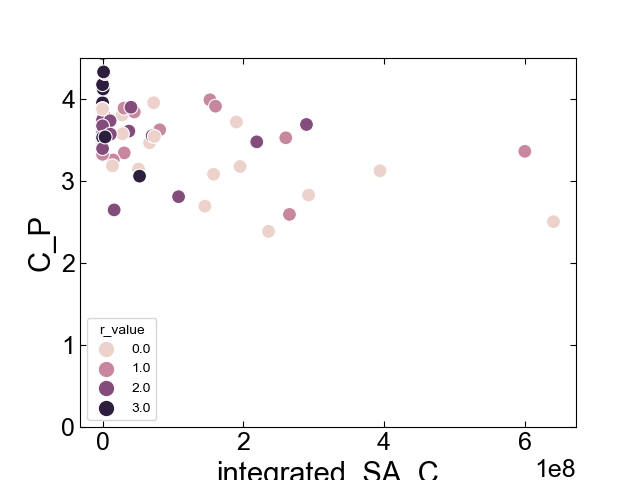

In [46]:
fig,ax = plt.subplots()
df = df[df['plate']!=431]
select = df[df['treatment']=='100P']
select = select[select['t2 (day)']<=9]
select = select[select['arrangement'].isin(['coarse','basic'])]


sns.scatterplot(select,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="r_value")
# ax.set_xscale('log')
# ax.hlines(mean0P,0,2e9, color = "grey",label = "test samples (0P)")
ax.set_ylim(0,4.5)
plt.show()

In [71]:
grouped_r[grouped_r['r_value']==3]

,plate,type,time_elapsed_day,t1 (day),treatment,t2 (day),arrangement,day_start,r_value,totP (ug),tot_wet_weight,wet_weight_median,wet_weight_measured,dry weight,integrated_SA,C_P
3,416.0,agar,32.0,27.0,100P,5.0,basic,2023-06-08,3.0,13.711727,3.5120,1.0030,3.5670,0.0,1.222052e+06,3.904250
7,420.0,agar,32.0,27.0,100P,5.0,basic,2023-06-08,3.0,15.204029,3.6010,1.0220,3.6530,0.0,3.991386e+06,4.222168
11,427.0,agar,32.0,29.0,100P,3.0,basic,2023-06-08,3.0,20.798321,3.5130,1.0330,3.5570,0.0,1.000171e+04,5.920387
17,439.0,agar,35.0,32.0,100P,3.0,coarse,2023-07-03,3.0,13.477883,3.8203,3.8203,3.9497,0.0,3.512152e+05,3.527965
23,443.0,agar,24.0,17.0,100P,7.0,coarse,2023-07-03,3.0,8.257949,2.7013,2.7013,2.7930,0.0,1.421159e+08,3.057028
33,470.0,agar,21.0,16.0,0P,5.0,coarse,2023-07-17,3.0,10.122238,3.5447,3.5447,3.5965,0.0,3.643686e+04,2.855598
47,486.0,agar,60.0,56.0,100P,4.0,coarse,2023-08-14,3.0,13.676368,3.8700,3.8700,3.9450,0.0,1.409714e+07,3.533945


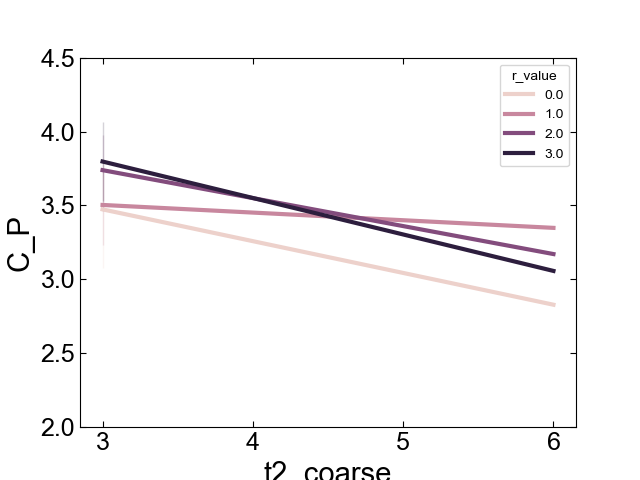

In [94]:
fig,ax = plt.subplots()
df = grouped_r[grouped_r['plate']!=431]
select = grouped_r[grouped_r['treatment']=='100P']
select = select[select['t2 (day)']<=9]
select = select[select['C_P']<=5]

select = select[select['arrangement'].isin(['coarse','basic'])]


# sns.scatterplot(select,x = 't2 (day)',y = 'C_P',ax = ax,hue ="r_value")
sns.lineplot(select,x = 't2_coarse',y = 'C_P',ax = ax,hue ="r_value",estimator = "mean")
# sns.lmplot(select,x = 't2 (day)',y = 'C_P',hue ="r_value")

# ax.set_xscale('log')
# ax.hlines(mean0P,0,2e9, color = "grey",label = "test samples (0P)")
ax.set_ylim(2,4.5)
plt.show()

In [78]:
grouped_r['t2_coarse'] = grouped_r['t2 (day)']//3*3

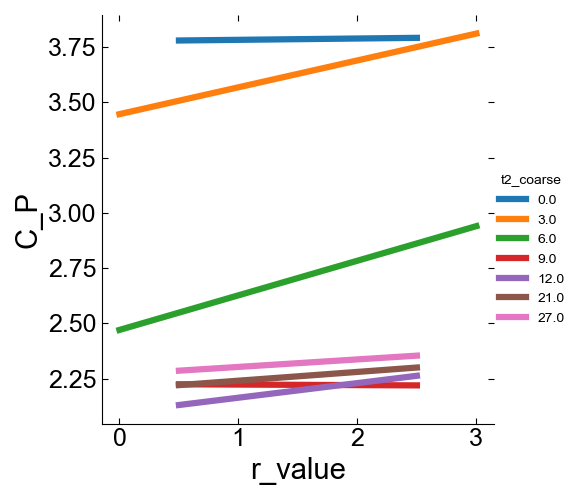

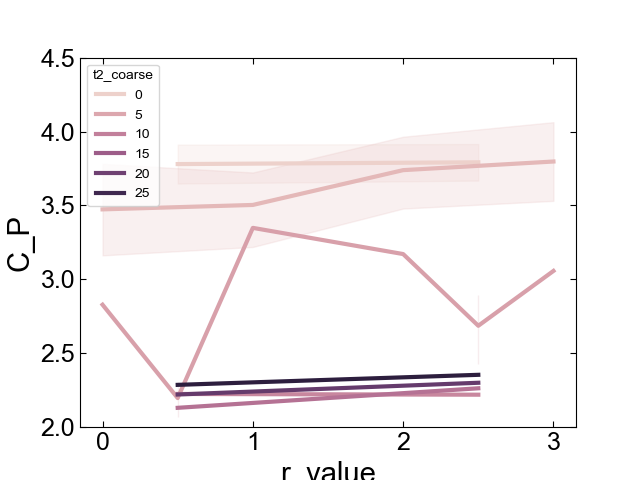

In [98]:
fig,ax = plt.subplots()
select = grouped_r[grouped_r['treatment']=='100P']
select = select[select['t2 (day)']<=30]
select = select[select['C_P']<=5]

select = select[select['arrangement'].isin(['coarse','basic','simple'])]
# select = select[select['arrangement'].isin(['coarse','basic'])]



# sns.scatterplot(select,x = 'r_value',y = 'C_P',ax = ax,hue ="t2 (day)")
sns.lineplot(select,x = 'r_value',y = 'C_P',ax = ax,hue ="t2_coarse",estimator = "mean",)
# sns.lineplot(select,x = 'r_value',y = 'C_P',ax = ax,estimator = "median",)

sns.lmplot(select,x = 'r_value',y = 'C_P',hue ="t2_coarse",ci=None,scatter=False)


# ax.set_xscale('log')
# ax.hlines(mean0P,0,2e9, color = "grey",label = "test samples (0P)")
ax.set_ylim(2,4.5)
plt.show()

In [20]:
df

,Sample_name,type,treatment,start,day_sample,arrangement,crossed,plate,unique_id,wet weight,...,time_elapsed_day,time_since_crossing,t2 (day),t1 (day),wet_weight_measured,pos,integrated_SA,C_P,P_content,integrated_SA_C
0,427-1,agar,100P,2023-06-08,2023-07-10,basic,NaN,427.0,427_20230707,1.6760,...,32.0,3 days,3.0,29.0,1.696,1,4.682950e+07,3.801558,NaN,2.794123e+07
1,427-2,agar,100P,2023-06-08,2023-07-10,basic,NaN,427.0,427_20230707,1.6140,...,32.0,3 days,3.0,29.0,1.634,2,9.370905e+07,4.566716,NaN,5.806013e+07
2,427-3,agar,100P,2023-06-08,2023-07-10,basic,NaN,427.0,427_20230707,1.6860,...,32.0,3 days,3.0,29.0,1.706,3,2.545553e+05,3.561483,NaN,1.509818e+05
3,427-4,agar,100P,2023-06-08,2023-07-10,basic,NaN,427.0,427_20230707,1.6650,...,32.0,3 days,3.0,29.0,1.685,4,0.000000e+00,3.420752,NaN,0.000000e+00
4,427-5,agar,100P,2023-06-08,2023-07-10,basic,NaN,427.0,427_20230707,1.6900,...,32.0,3 days,3.0,29.0,1.720,5,1.674310e+06,3.618668,NaN,9.907162e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,483-1,agar,100P,2023-08-14,2023-10-13,simple,NaN,483.0,483_20231005,9.7640,...,60.0,8 days,8.0,52.0,9.856,1,2.325297e+09,2.737510,NaN,2.381501e+08
240,490-0,agar,100P,2023-08-07,2023-10-13,simple,NaN,490.0,490_20231003,15.7700,...,67.0,10 days,10.0,57.0,15.916,0,1.368683e+10,2.224827,NaN,8.679032e+08
241,490-1,agar,100P,2023-08-07,2023-10-13,simple,NaN,490.0,490_20231003,10.0460,...,67.0,10 days,10.0,57.0,10.163,1,6.178655e+09,2.219852,NaN,6.150364e+08
244,485-0,agar,100P,2023-08-14,2023-10-13,simple,NaN,485.0,485_20230929,15.7080,...,60.0,14 days,14.0,46.0,15.985,0,1.997185e+10,2.131089,NaN,1.271445e+09


In [13]:
select['unique_id'].unique()

array(['427_20230707', '416_20230705', '420_20230705', '460_20230807',
       '443_20230720', '439_20230804', '486_20231009', '495_20231013',
       '491_20231013', '481_20231005', '483_20231005'], dtype=object)

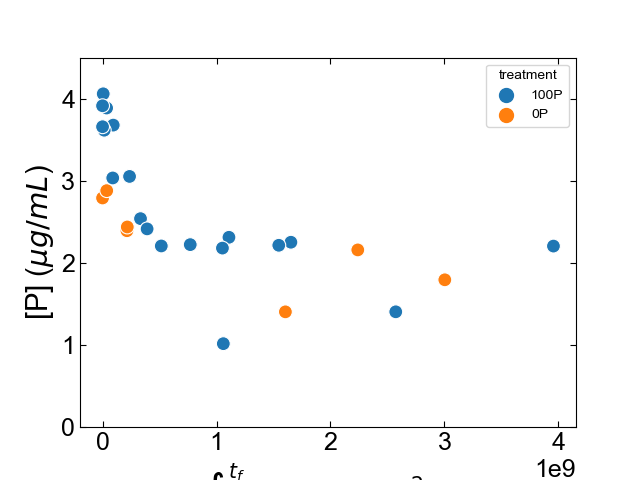

In [14]:
fig,ax = plt.subplots()
grouped = grouped[grouped['plate']!=431]



# sns.scatterplot(df,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="treatment",s = 6)
sns.scatterplot(grouped,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="treatment")
# ax.set_xscale('log')
ax.set_ylim(0,4.5)
plt.ylabel('[P] ($\mu g/mL$)')
plt.xlabel('$\int_0^{t_f} SA(t)dt$ ($\mu m^2h$)')
# plt.savefig(os.path.join('figures', 'P_SA.pdf'), transparent=True, bbox_inches='tight')
# for index,row in grouped.iterrows():
#     plt.text(row['integrated_SA_C'],row['C_P'],row['plate'])
plt.show()
plt.tight_layout()

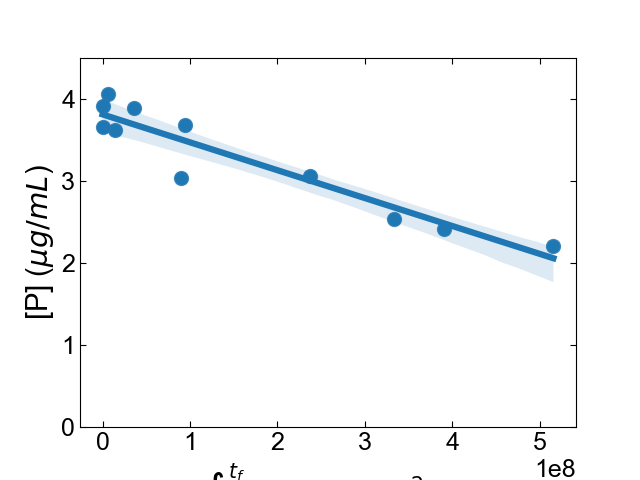

In [15]:
fig,ax = plt.subplots()
grouped = grouped[grouped['plate']!=431]
select = grouped[grouped['t2 (day)']<=9]
select = select[select['treatment']=='100P']



# sns.scatterplot(df,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="treatment",s = 6)
sns.scatterplot(select,x = 'integrated_SA_C',y = 'C_P',ax = ax)
sns.regplot(select,x = 'integrated_SA_C',y = 'C_P',ax = ax)

# ax.set_xscale('log')
ax.set_ylim(0,4.5)
plt.ylabel('[P] ($\mu g/mL$)')
plt.xlabel('$\int_0^{t_f} SA(t)dt$ ($\mu m^2h$)')
# plt.savefig(os.path.join('figures', 'P_SA.pdf'), transparent=True, bbox_inches='tight')
# for index,row in grouped.iterrows():
#     plt.text(row['integrated_SA_C'],row['C_P'],row['plate'])
plt.show()
plt.tight_layout()

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(select['integrated_SA_C'], select['C_P'])

In [17]:
slope

-3.3973588349543932e-09

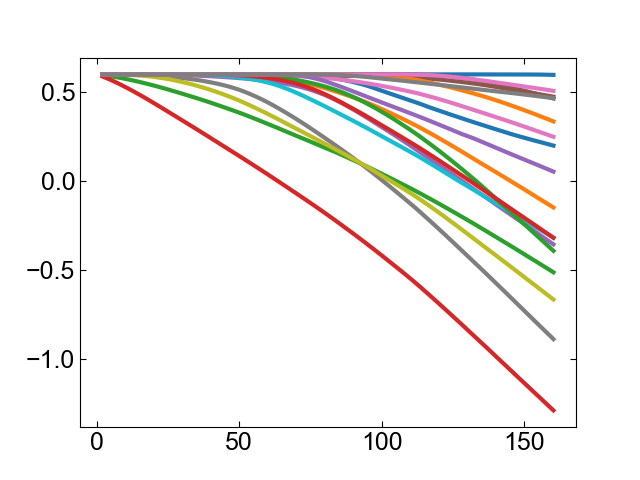

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named time_plate_info
# Replace 'your_data.csv' with your actual data source if needed
# time_plate_info = pd.read_csv('your_data.csv')

# Create a list of unique IDs
unique_ids = time_plate_info['unique_id'].unique()
unique_ids = ['474_20230807']
fig,ax = plt.subplots()
# Loop through each unique ID and plot the data
for unique_id in unique_ids:
    # Filter the DataFrame for the current unique ID
    df_subset = time_plate_info[time_plate_info['unique_id'] == int(unique_id)]
    
    # Extract the relevant columns
    time_since_begin_h = df_subset['time_since_begin_hour']
    select = df[df['arrangement'] == 'basic']
    
    for i in range(18):
        subselect = select[select['pos']==i+1]
        length_density_region_0 = 0.6+df_subset[f'integrated_SA_{i}']/np.mean(subselect['wet weight'])*slope
    
    # Create a plot for the current unique ID
        ax.plot(time_since_begin_h, length_density_region_0, label=f'ID {unique_id}')
    
    # Customize plot labels, title, etc. as needed
  
    # Optionally, save the plot to a file using plt.savefig('plot_filename.png')

# If you want to display all plots at once, remove plt.show() from the loop


In [19]:
slope,afea

NameError: name 'afea' is not defined

In [ ]:
fig,ax = plt.subplots()
grouped = grouped[grouped['plate']!=431]
select = select[select['t2 (day)']<=9]
select = select[select['treatment']=='100P']



# sns.scatterplot(df,x = 'integrated_SA_C',y = 'C_P',ax = ax,hue ="treatment",s = 6)
sns.scatterplot(select,x = 't2 (day)',y = 'C_P',ax = ax)
sns.regplot(select,x = 't2 (day)',y = 'C_P',ax = ax)

# ax.set_xscale('log')
ax.set_ylim(0,5)
plt.ylabel('[P] ($\mu g/mL$)')
plt.xlabel('time since crossing (day)')
# plt.savefig(os.path.join('figures', 'P_SA.pdf'), transparent=True, bbox_inches='tight')
# for index,row in grouped.iterrows():
#     plt.text(row['integrated_SA_C'],row['C_P'],row['plate'])
plt.show()
plt.tight_layout()

In [ ]:
# import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd

# Define the Michaelis-Menten differential equation
def mm_eq(S, t, A_t, Vmax, Km):
    return -Vmax * (A_t * S / (Km + S))

# Objective function to minimize
def objective(params, all_times, all_areas, all_final_concentrations, all_initial_concentrations):
    Vmax, Km = params
    total_error = 0

    # Loop over each unique time series
    for times, areas, final_S,initial_concentration in zip(all_times, all_areas, all_final_concentrations,all_initial_concentrations):
        S = initial_concentration
        # Integrate for each time step within this series
        last_time = 0  # Keep track of the last time point

        # Integrate for each time step within this series
        for t, a in zip(times, areas):
            S = odeint(mm_eq, S, [last_time, t], args=(a, Vmax, Km))[-1]
            last_time = t  # Update the last time point for the next iteration
        # Sum of squared error for this series
        if not np.isnan(S):
            total_error += (S - final_S)**2
        # if np.isnan(total_error):
        #     print(total_error,times,areas)
        #     break
    print(total_error)
    return total_error


In [ ]:
time_plate_info

***region***

In [ ]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# Sorting the DataFrame just in case
time_plate_info = time_plate_info.sort_values(['unique_id', 'time_since_begin_hour'])

all_times = []
all_areas = []
all_final_concentrations=[]
unique_ids = time_plate_info['unique_id'].unique()
all_ids = []

shift= 2.4

# Loop over each unique_id
for unique_id in unique_ids:
    select_df = df[df['unique_id'].astype(np.int64)==unique_id]
    subset_df = time_plate_info[time_plate_info['unique_id'] == unique_id]
    time_series = subset_df['time_since_begin_hour'].values
    for index,row in select_df.iterrows():
        arrangement = row['arrangement']
        index = row['pos']
        vol = row['wet weight']
        P_C = row['C_P']
        treatment = row['treatment']
        indexes = get_regions(arrangement, index)
        area_series = [subset_df[f'SA_region_{i}'].values for i in indexes]
        
        # Append the time and area series to the lists
        if P_C<5 and treatment!='0P' and len(time_series)>0:
            all_times.append(time_series)
            all_areas.append(np.sum(area_series,axis=0)/vol)
            all_final_concentrations.append(max(P_C-shift,0))
            all_ids.append(unique_id)
            
# Now, all_times and all_areas contain the time and area series for each unique_id and each region
initial_concentration = 3.9-shift

***whole plate***

In [ ]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# Sorting the DataFrame just in case
time_plate_info = time_plate_info.sort_values(['unique_id', 'time_since_begin_hour'])

all_times = []
all_areas = []
all_final_concentrations=[]
all_initial_concentrations=[]

all_ids = []
unique_ids = df['unique_id'].unique()
shift= 2.4
# Loop over each unique_id
for unique_id in unique_ids:
    select_df = df[df['unique_id']==unique_id]
    subset_df = time_plate_info[time_plate_info['unique_id'] == int(unique_id)]
    time_series = subset_df['time_since_begin_hour'].values
    area_series = [subset_df[f'SA_region_{i}'].values for i in range(18)]        # Append the time and area series to the lists
    vol = np.sum(select_df['wet weight'])
    P_C = np.sum(select_df['totP (ug)'])/vol
    treatment = select_df['treatment'].iloc[0]
    if P_C<5 and len(time_series)>0:
        all_times.append(time_series)
        all_areas.append(np.sum(area_series,axis=0)/vol)
        all_final_concentrations.append(max(P_C-shift,0))
        all_ids.append(unique_id)
        if treatment=='0P':
            all_initial_concentrations.append(2.9-shift)
        else:
            all_initial_concentrations.append(3.9-shift)
# Now, all_times and all_areas contain the time and area series for each unique_id and each region
# initial_concentration = 3.9-shift

In [ ]:
initial_guesses = [1e-8,1]
initial_concentration = 3.9-shift
deltas = np.array([1e-7, 10])
init_params = initial_guesses
simplex = [init_params]
for i in range(len(init_params)):
    new_point = np.copy(init_params)
    new_point[i] += deltas[i]
    simplex.append(new_point)

# Convert to numpy array for use in scipy.minimize
initial_simplex = np.array(simplex)
result = minimize(objective, initial_guesses, args=(all_times, all_areas, all_final_concentrations, all_initial_concentrations), method='Nelder-Mead', options={'initial_simplex': initial_simplex,"xatol" : 0.1})
Vmax, Km = result.x

# Print results
print(f"Best-fitting parameters: Vmax = {Vmax}, Km = {Km}")

In [ ]:
all_initial_concentrations

In [ ]:
print(f"Best-fitting parameters: Vmax = {Vmax}, Km = {Km}")

In [ ]:
#Schnepf value
3e-6*31*3600 #ug.h-1.cm-2

In [ ]:
predicted_final_concentrations = []
actual_final_concentrations = all_final_concentrations  # Assuming this is already available
Vmax, Km = result.x
plt.figure()

# Calculate predicted final concentrations
for times, areas, final_C,unique_id,initial_concentration in zip(all_times, all_areas,all_final_concentrations,all_ids,all_initial_concentrations):
    predicted_S = get_predicted_concentration(times, areas, Vmax, Km, initial_concentration)
    if len(predicted_S)>0:
        predicted_final_concentrations.append(predicted_S[-1])
        plt.scatter(final_C,predicted_S[-1],marker = "+")
        # plt.text(final_C,predicted_S[-1],unique_id)
# Create the plot
# plt.scatter(actual_final_concentrations, predicted_final_concentrations, c='blue')
plt.xlabel('Actual [P]')
plt.ylabel('Predicted [P]')

# Plot a 45-degree line for reference
min_val = min(min(actual_final_concentrations), min(predicted_final_concentrations))
max_val = max(max(actual_final_concentrations), max(predicted_final_concentrations))
# print(objective([Vmax, Km],all_times,all_areas,all_final_concentrations,initial_concentration))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.savefig(os.path.join('figures', 'modelfit.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
def get_predicted_concentration(times, areas, Vmax, Km, initial_concentration):
    S = initial_concentration
    last_time = 0  # Initialize the last time point
    S_values = []  # To store concentration at each time point
    
    # Integrate for each time step
    for t, a in zip(times, areas):
        S = odeint(mm_eq, S, [last_time, t], args=(a, Vmax, Km))[-1]
        S_values.append(S[0])  # Storing concentration at each time step
        last_time = t  # Update the last time point for next iteration
    
    return np.array(S_values)
plt.figure()

# Assuming you have a single time series for demonstration (replace with your actual time series)
i=0
for times, areas, initial_concentration in zip(all_times, all_areas,all_initial_concentrations):
    predicted_S_values = get_predicted_concentration(times, areas, Vmax, Km, initial_concentration)
    if len(predicted_S_values)>0:
        concentration = all_final_concentrations[i]
        plt.plot(times, predicted_S_values, alpha = 0.5)
        plt.scatter(times[-1],actual_final_concentrations[i],marker = "+")
        plt.plot([times[-1],times[-1]],[predicted_S_values[-1],actual_final_concentrations[i]],color = "black")
        
    i+=1
    # break

# Plotting predicted trajectory

plt.xlabel('Time since crossing (h)')
plt.ylabel('[P] ($\mu g/mL$)')
# plt.legend()
plt.savefig(os.path.join('figures', 'Time_concentration.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
# Assuming you have a single time series for demonstration (replace with your actual time series)
plt.figure()

i=0
for times, areas in zip(all_times, all_areas):
    plt.plot(times, areas, label=unique_ids[i])
    # plt.scatter(times[-1],actual_final_concentrations[i])
    i+=1
    
# Plotting predicted trajectory

plt.xlabel('Time since crossing (h)')
plt.ylabel('Surface Area ($\mu m^2$)')
# plt.legend()
plt.yscale('log')
plt.savefig(os.path.join('figures', 'time_SA.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
# Assuming you have a single time series for demonstration (replace with your actual time series)
plt.figure()

i=0
for times, areas in zip(all_times, all_areas):
    plt.plot(times, areas, label=unique_ids[i])
    # plt.scatter(times[-1],actual_final_concentrations[i])
    i+=1
    
# Plotting predicted trajectory

plt.xlabel('Time since crossing (h)')
plt.ylabel('Surface Area ($\mu m^2$)')
# plt.legend()
# plt.yscale('log')
plt.savefig(os.path.join('figures', 'time_SA.pdf'), transparent=True, bbox_inches='tight')


In [ ]:
def get_regions(arrangement, index):
    coarse_to_basic_mapping = {
    1: [1, 2],
    2: [3, 8],
    3: [4, 5],
    4: [6, 7],
    5: [9, 10],
    6: [11, 12],
    7: [13],
    8: [14, 15],
    9: [16, 17, 18]
}

    # Mapping for "simple" to "basic"
    simple_to_basic_mapping = {
        0: list(range(1, 11)),
        1: list(range(11, 19))
    }
    if arrangement == 'basic':
        indexes = [index-1]
    if arrangement == 'simple':
        indexes = [basic_pos-1 for basic_pos in simple_to_basic_mapping[index]]
    if arrangement == 'coarse':
        indexes = [basic_pos-1 for basic_pos in coarse_to_basic_mapping[index]] 
    return(indexes)

In [ ]:
fig,ax = plt.subplots()
for index,time in enumerate(all_times):
    ax.plot(time,all_areas[index])
# all_areas

In [ ]:
from PIL import Image
df = df[df['type'] != 'root']
df = df[df['type'] != 'rootagar']
df['pos'] = df['Sample_name'].str.split('-').str.get(1).astype(int)
df['C_P'] = df['totP (ug)']/df['wet weight'] 
basic_mapping = {
    1: (0, 0), 2: (0, 1), 3: (0, 2), 4: (0, 3), 5: (0, 4),
    6: (1, 0), 7: (1, 1), 8: (1, 2), 9: (1, 3), 10: (1, 4),
    11: (2, 0), 12: (2, 1), 13: (2, 2), 14: (2, 3), 15: (2, 4),
    16: (3, 1), 17: (3, 2), 18: (3, 3)
}

# Mapping for "coarse" to "basic"
coarse_to_basic_mapping = {
    1: [1, 2],
    2: [3, 8],
    3: [4, 5],
    4: [6, 7],
    5: [9, 10],
    6: [11, 12],
    7: [13],
    8: [14, 15],
    9: [16, 17, 18]
}

# Mapping for "simple" to "basic"
simple_to_basic_mapping = {
    0: list(range(1, 11)),
    1: list(range(11, 19))
}

# Initialize plot
plt.close("all")
for idx, unique_id in enumerate(df['unique_id'].unique()):
    if type(unique_id) ==str:
        fig,ax = plt.subplots()
        plate_df = df[df['unique_id'] == unique_id]

        # Create an empty 4x5 grid (for "basic" arrangement, adjust as needed)
        grid = np.zeros((4, 5))

        for i, row in plate_df.iterrows():
            arrangement = row['arrangement']
            pos = row['pos']
            totP = row['integrated_SA']
            totP = row['C_P']
            

            if arrangement == 'basic':
                x, y = basic_mapping[pos]
                grid[x, y] = totP

            elif arrangement == 'simple':
                for basic_pos in simple_to_basic_mapping[pos]:
                    x, y = basic_mapping[basic_pos]
                    grid[x, y] = totP

            elif arrangement == 'coarse':
                for basic_pos in coarse_to_basic_mapping[pos]:
                    x, y = basic_mapping[basic_pos]
                    grid[x, y] = totP

        # Plotting the grid
        image_path = os.path.join("C:\\Users\\coren\\AMOLF-SHIMIZU Dropbox\\DATA\\PRINCE_ANALYSIS", unique_id)

        # Find the image in the folder with name like 'StitchedImage_YYYYMMDD_hhmm.tif'
        for image_file in os.listdir(image_path):
            if 'StitchedImage' in image_file:
                img = Image.open(os.path.join(image_path, image_file))

        # Display the image
        ax.imshow(np.array(img), cmap='gray', extent=[-0.5, 4.5, -0.5, 3.5])
        c = ax.imshow(grid, cmap='Reds', aspect='auto',alpha = 0.5)
        cbar = fig.colorbar(c, ax=ax)
        cbar.set_label('P contration (ug/mL)', rotation=270, labelpad=20)
        ax.set_title(f'Plate {unique_id}')
        ax.set_xticks([])
        ax.set_yticks([])
        
    # break
# plt.show()